In [5]:
import pandas as pd
import seaborn as sns
from scipy import stats

import genpred

# Capsule knock-out analysis

## 1. Methods 

In this notebook, we are going to see the effect of removing the capsule loci from genomes that are classified in the capsule-B group with high confidence. First, let's recap what the experiment consists of:

- we filter all genomes where the prediction is `capsule-B` with high confidence (>= 0.99), and discard all the other genomes, for a total of 497 genomes.
- of these, we further filter all genomes where the capsule loci (all bases from gene `NEIS0044` to gene `NEIS0068`) is contained in a single contig. This reduces the set of genomes for this experiment to `32`.
- we remove the locus, compute the prediction after the knock-out, and compare it to the prediction before the knock-out.

## 2. Results

### 2.1 Model predictions change significantly (wrt control) once capsule loci are knocked out

First, we load the knockout and control groups data and display some statistics.

In [6]:
capsule_control_data = pd.read_csv(genpred.EXPS_ROOT / "knockout/capsule/sentencepiece/8000/capsule-control/predictions.csv")
print("Number of genomes:", len(capsule_control_data))
print(f"Mean length of bases removed (control group): {capsule_control_data.Length.mean()} +/- {capsule_control_data.Length.std()}")
print(f"Mean prediction before knockout (control group): {capsule_control_data.Before.mean()} +/- {capsule_control_data.Before.std()}")
print(f"Number of capsule-B genomes before knockout (control group): {(capsule_control_data.Before>0.5).sum()}")
print(f"Mean prediction after knockout (control group): {capsule_control_data.After.mean()} +/- {capsule_control_data.After.std()}")
print(f"Number of capsule-B genomes after knockout (control group): {(capsule_control_data.After>0.5).sum()}")
print(f"Number of switchs from capsule-B to capsule not-B after knockout (control group): {len(capsule_control_data) - (capsule_control_data.After>0.5).sum()}")
print()

Number of genomes: 32
Mean length of bases removed (control group): 25663.15625 +/- 696.7256649627183
Mean prediction before knockout (control group): 0.9999995613357322 +/- 2.162938330551989e-06
Number of capsule-B genomes before knockout (control group): 32
Mean prediction after knockout (control group): 0.9999995268581596 +/- 2.3430899844594444e-06
Number of capsule-B genomes after knockout (control group): 32
Number of switchs from capsule-B to capsule not-B after knockout (control group): 0



In [7]:
capsule_ko_data = pd.read_csv(genpred.EXPS_ROOT / "knockout/capsule/sentencepiece/8000/capsule/predictions.csv")
print("Number of genomes:", len(capsule_ko_data))
print(f"Mean length of bases removed (knockout group): {capsule_control_data.Length.mean()} +/- {capsule_control_data.Length.std()}")
print(f"Mean prediction delta before knockout (knockout group): {capsule_ko_data.Before.mean()} +/- {capsule_ko_data.Before.std()}")
print(f"Number of capsule-B genomes before knockout (knockout group): {(capsule_ko_data.Before>0.5).sum()}")
print(f"Mean prediction delta after knockout (knockout group): {capsule_ko_data.After.mean()} +/- {capsule_ko_data.After.std()}")
print(f"Number of capsule-B genomes after knockout (knockout group): {(capsule_ko_data.After>0.5).sum()}")
print(f"Number of switchs from capsule-B to capsule not-B after knockout (knockout group): {len(capsule_ko_data) - (capsule_ko_data.After>0.5).sum()}")

Number of genomes: 32
Mean length of bases removed (knockout group): 25663.15625 +/- 696.7256649627183
Mean prediction delta before knockout (knockout group): 0.9999995613357322 +/- 2.162938330551989e-06
Number of capsule-B genomes before knockout (knockout group): 32
Mean prediction delta after knockout (knockout group): 0.08778123290826002 +/- 0.2452001932889944
Number of capsule-B genomes after knockout (knockout group): 2
Number of switchs from capsule-B to capsule not-B after knockout (knockout group): 30


Clearly, removing the capsule has had a strong impact, since the mean prediction changes drastically once the the capsule removed while staying essentially the in the control group. To reinforce the concept, we show a plot of the delta in predictions of the two groups:

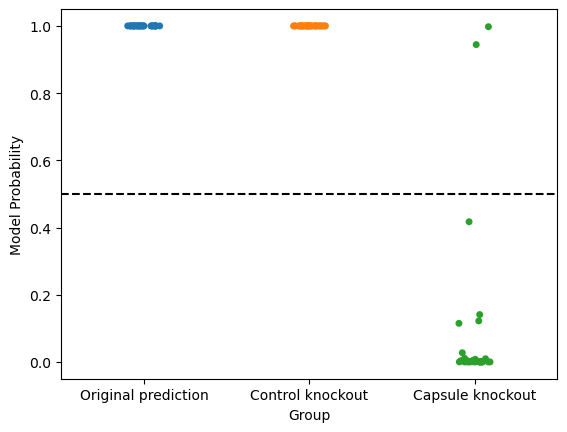

In [8]:
data = pd.DataFrame({"Genome": capsule_control_data.Genome, "Original prediction": capsule_control_data.Before, "Control knockout": capsule_control_data.After, "Capsule knockout": capsule_ko_data.After})
ax = sns.stripplot(data=data)
ax.axhline(y=0.5, color="k", linestyle="--")
ax.set_ylabel("Model Probability")
ax.set_xlabel("Group");

data.to_csv("fig5_panelA.csv", index=False)

From the plot, it is apparent that most `capsule-B` genomes switch predictions to `non-capsule-B` once the capsule loci are removed. Lastly, we show that the deltas observed in the knock-out group are significantly different than the deltas observed in the control group. To do so, we use a Wilcoxon signed rank test (null hypothesis: **no difference between the deltas in the control group and the deltas in the knockout group**). We reject the null hypothesis at a significance level $\alpha = 0.05$:

In [9]:
SIGNIFICANCE_LEVEL = 0.05

pvalue = stats.wilcoxon(data["Control knockout"], data["Capsule knockout"]).pvalue

if pvalue < SIGNIFICANCE_LEVEL:
    print(f"Null hypothesis rejected (p-value {pvalue})")
else:
    print(f"Not enough evidence to reject the null hypothesis (p-value {pvalue})")


Null hypothesis rejected (p-value 4.656612873077393e-10)
